# **AP155 Lab Assignment**
## Module 5: Partial Differential Equations

_Instructions_: Answer each problem as completely as you can. Discuss **all** your answers as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.



### Student Information

_Full Name (Last Name, First Name)_: Darwin P. Manalo Jr.\
_Student No._: 2022-10113\
_Section_: THV-TX-2

### Submission Information

_Date and Time Submitted (most recent upload)_: November 11, 2024

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Darwin P. Manalo Jr.**

### Grading Information (c/o Lab Instructor)

TOTAL SCORE: <font color='red'>**100/100**</font>

Score breakdown:
* Problem 1 - <font color='red'>**100/100**</font>

<font color='red'>**signed GC Belinario**</font>

### PROBLEM 1
**The Schrodinger equation and the Crank-Nicolson method**

_Refer to Exercise 9.8 in the Newman text._ In this problem, you will use the Crank-Nicolson method to solve the full time-dependent Schrodinger equation and hence develop a picture of how a wavefunction evolves over time.

Consider an electron (mass $M = 9.109 \times 10^{-31}$ kg) in a box of length $L = 10^{-8}$ m. Suppose that at time $t = 0$ the wavefunction of the electron has the form

$$ \psi(x,0) = \exp\left[-\frac{(x-x_0)^2}{2\sigma^2}\right]e^{i\kappa x},$$
where $x_0 = \frac{L}{2}$, $\sigma = 1 \times 10^{-10}$ m, $\kappa = 5 \times 10^{10} {\rm m}^{-1}$,  and $\psi = 0$ on the walls at $x = 0$ and $x = L$.

1. Perform a single step of the Crank-Nicolson method for this electron, calculating the vector $\psi(t)$ of values of the wavefunction, given the initial wavefunction above and using $N = 1000$ spatial slices with $a = L/N$. Your program will have to perform the following steps. First, given the vector $\psi(0)$ at $t = 0$, you will have to multiply by the matrix $\bf{B}$ to get a vector $\bf{v} = \bf{B}\psi$. Because of the tridiagonal form of $\bf{B}$, this is fairly simple. The $i$th component of $\bf{v}$ is given by
$$ v_i = b_1\psi_i + b_2(\psi_{i+1} + \psi_{i-1}).$$

   You will also have to choose a value for the time-step $h$. A reasonable choice is $h = 10^{-18}$ s. *(30 pts.)*

2. Second you will have to solve the linear system ${\bf Ax}= {\bf v}$ for $\bf{x}$, which gives you the new value of $\psi$. You could do this using a standard linear equation solver like the function $\tt solve$ in numpy's $\tt linalg$. *(20 pts.)*

3. Once you have the code in place to perform a single step of the calculation, extend your program to perform repeated steps and hence solve for $\psi$ at a sequence of times a separation $h$ apart. Note that the matrix $\bf A$ is independent of time, so it doesn't change from one step to another. You can set up the matrix just once and then keep on reusing it for every step. *(30 pts.)*

4. Make an animation of the solution by displaying the real part of the wavefunction at each time-step. You can use the function rate from the package visual to ensure a smooth frame-rate for your animation-- see Section 3.5 on page 117 of the Newman text.

   Run your animation for a while and describe what you see. Write a few sentences explaining in physics terms what is going on in the system. *(20 pts.)*

In [15]:
from numpy import copy, exp, repeat, arange, zeros, concatenate # importing necessary functions
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Constants
hbar = 1.054572e-34 # Reduced Planck's constant
# particle and potential well parameters
M = m = 9.109e-31   # mass (kg)
L = 1e-8       # Length of 1D box or potential well
# Wave function parameters
sigma = 1e-10   # standard deviation of the Gaussian, controlling its width
K = 5e10        # Kappa as the wave number determining the momentum of the particle
N = 1000        # spatial slices
a = L/N         # spatial step
x_0 = L/2       # center of the initial wavepacket
h = 1e-18       # time step

In [16]:
# Newmann Appendix E.2: fast solver for banded matrices
def banded(Aa, va, up, down): # Function used to solve systems of linear equations using Gaussian elimination for a banded matrix
  A = copy(Aa) # Copies the banded matrix (before modification) to avoid modifying the original matrix
  v = copy(va) # Copies the vector representing the values (right hand side of the equation)
  N = len(v)   # Stores the length of the vector v, which corresponds to the size of the ssystem
  # Gaussian elimination
  for m in range(N): # iterates over each row of the matrix
    # Normalization factor
    div = A[up, m] # Divides the pivot element by itself to normalize the row
    # Update the vector first
    v[m] /= div # Divides the corresponding element in the RHS vector 'v' by the pivot element to normalize it
    for k in range(1, down+1): # This loop subtracts the conditions of the elements below the pivot, eliminating the lower diagonal entries
      if m+k < N:
        v[m+k] -= A[up + k, m] * v[m] # Updates the vector 'v' to eliminate the lower diagonal
    # Now normalize and subtract the pivot row
    for i in range(up): # Updates the matrix A to eliminate elements above the pivot
      j = m + up - i
      if j < N:
        A[i,j] /= div # Divide the matrix element by the pivot to normalize
        for k in range(1, down+1):
          A[i+k, j] -= A[up+k, m] * A[i,j] # Subtracts the contributions from the current row to eliminate the above-diagonal entries
  # Backsubstitution
  for m in range(N-2, -1, -1): # iterates over the rows in reverse order
    for i in range(up):
      j = m + up - i
      if j<N:
        v[m] -= A[i,j] * v[j] # Updates the solution vector 'v' by subracting the contributions of already solved variables
  return v # Returns the updated solution

In [17]:
# Initial wavefunction definition
def psi_t0(x): # Defines the initial wave function at time t=0
  return exp(-(x-x_0)**2 / (2*sigma**2)) * exp(1j*K*x) # The wavefunction is a Gaussian wave packet modulated by a plane wave with wave number K

# Time Evolution and solving the wavefunction
def solve_psi(psi): # Updates the wavefunction at the next time step
  v[1:-1] = b1*psi[1:N-1] + b2*(psi[2:N] + psi[0:N-2]) # The right-hand side (RHS) of the equation using the coefficients b1 and b2 to update the inner elements
  return banded(A_banded, v, 1, 1) # Solves the system of equations for the updated wavefunction using the banded matrix solver
# Crank-Nicolson Coefficients
a1 = 1 + h*(1j*hbar)/(2*m*a**2) # diagonal elements
a2 = -h*(1j*hbar)/(4*m*a**2)    # off-diagonal elements
b1 = 1-h*(1j*hbar)/(2*m*a**2)   # diagonal elements
b2 = h*(1j*hbar)/(4*m*a**2)     # off-diagonal elements
# Banded Matrix Setup
A_banded = repeat([[a2],[a1],[a2]], N, axis=1) # creates a banded matrix using the coeffficients
# Spatial grid
x_n = arange(0, L, a) # creates an array of evenly spaced points from 0 to L with step size of a
psi = psi_t0(x_n[1:-1]) # Initializes the wavefunction at t=0 and the boundaries are excluded using the indexing of [1:-1]
psi = concatenate(([0], psi, [0])) # This adds boundary conditions to the wavefunction
v = zeros(N, complex)


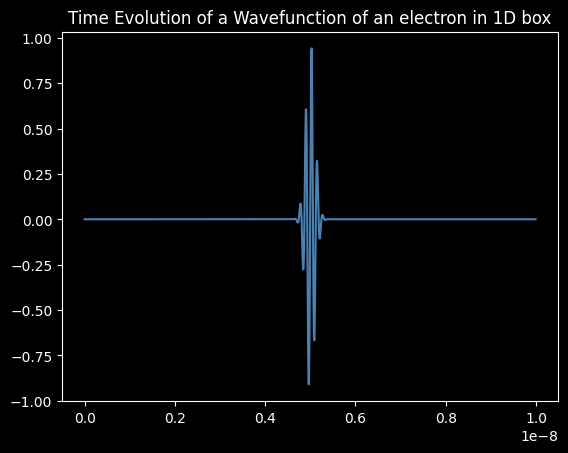

In [19]:
# Plot of wave at t=0
plt.plot(x_n, psi.real, color = 'steelblue')
plt.style.use('dark_background')
plt.title("Time Evolution of a Wavefunction of an electron in 1D box")
plt.show()


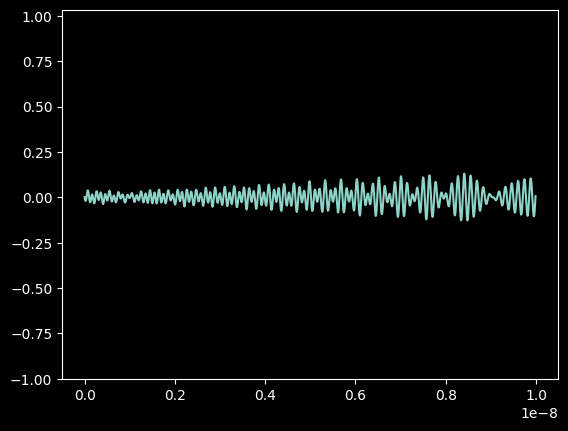

In [20]:
# animation
time_steps = 5000 # Setting the number of frames for the animation
fig, ax = plt.subplots() # Creates a figure and axes for the plot
wave = ax.plot(x_n, psi.real)[0] # initializes a plot of the real part of the wavefunction

def update(frame): # This function is called at each frame of the animation
  global psi
  psi = solve_psi(psi)
  wave.set_ydata(psi.real)
  return (wave,)

anim = FuncAnimation(fig, update, frames=time_steps, interval = 1, blit = True) # creates the animation by calling the update function at each frame
# anim.save('wavepacket.mp4', writer = 'ffmpeg', fps = 60)

from IPython.display import HTML
HTML(anim.to_html5_video())
# 5000 - 5m 46s

**Discussion**\
Initially, the wavefunction is defined as the Gaussian wave packet modulated by a plane wave where the term $e^{-\frac{(x-x_0)^2}{2\sigma^2}}$ describes a Gaussian envelope at $x_0=L/2$ which means that the particle is localized around the middle of the potential well while the term $e^{iKx}$ represents a plane wave with wave number 'K' corresponding to a particle with definite momentum. On the other hand, as shown in the results, as the simulation progresses and the wavefunction evolves over time, the wavefunction will spread out while maintaining its Gaussian shape with different peaks. After some time, the wavefunction starts to 'reflect' or 'bounce back' off the boundaries since the particle is confined in a potential well with infinite walls so it can't penetrate the boundaries which forced the particle to reflect off the walls. This is all due to the boundary conditions at which the wavefunction cannot exists at a region of infinite potential so it needs to bounce back. And as it reflects, the wave interferes with the incident wave which leads to the formation of **standing waves** in the well. These standing waves correspond to the solutions of the Time-Independent Schrodinger's equation in a box with infinite walls. After several reflections, the wavefunction develops a periodic pattern of the energy levels of the potential well and these levels coincide with the standing wave modes for a particle confined in a box. Lastly, over time, the wavefunction tends to redistribute its energy to different standing modes reflecting the quantized nature of the potential well. All of this is a consequence of the wave nature of particles and the confinement of these particles in the potential well.

If the video is not accesible as HTML video, please click this link https://colab.research.google.com/drive/10Dtj9wJXN-rW80NHs5UirycYEpPr_xth?usp=sharing

<font color=red>Correctness of Code: 50/50 </font> \
<font color=red>Discussion of Code and Results: 50/50 </font>